# Sentiment Analysis of Yelp Reviews - Pre Processing / Modeling

#### Prepared By: Ben Chamblee - https://github.com/Bench-amblee

## Contents

* [Introduction](#Introduction)
* [Categorization and Dummy Variables](#Dummy)
* [CountVectorizer](#CountVectorizer)
* [TFIDF](#TFIDF)
* [Bigrams and min/max_df](#grams)
* [Creating a Training Dataset](#Train)
* [Conclusion](#Conclusion)

## Introduction

In the last notebook, we explored the relationships in our data and found things like Polarity which help label our training data. In this notebook we're going to prepare our data so that we can use it as an effective train/test split for building a model in the final notebook

We need to do a few things:

- Categorize and label the data
- Convert the cleaned reviews into vector data
- Create a pipeline using a text vectorization method
- Test the newly categorized / vectorized data on a simple logistic regression

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

yelp_data = pd.read_csv('yelp_data_analyzed.csv')

In [2]:
yelp_data.head()

,Alias,Name,Rating,Price,City,Zip_code,Address,Review,Review_Word_Count,No_Stop_Words:Tokens,No_Stop_Words:Sentence,Stop_Word_Count,Stop_Words_%,Lemmatized,Stemmed:Sentence,Stemmed:Tokens,Polarity,Positive_Word_Count,Positive_Words_%,Stemmed_Word_Count
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'The chocolate cups are amazing! Have been eat...,16,"['chocolate', 'cups', 'amazing', 'eating', 'ye...",chocolate cups amazing eating years always ta...,7,0.437500,chocolate cup amazing eating year always taste...,chocol cup amaz eat year alway tast fantast,"['chocol', 'cup', 'amaz', 'eat', 'year', 'alwa...",0.500000,2,0.222222,8
1,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'Morris Park Bake Shop has become my go to spo...,49,"['morris', 'park', 'bake', 'shop', 'become', '...",morris park bake shop become go spot atmosphe...,20,0.408163,morris park bake shop become go spot atmospher...,morri park bake shop becom go spot atmospher p...,"['morri', 'park', 'bake', 'shop', 'becom', 'go...",0.338889,6,0.206897,28
2,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'I thought the cookies and biscotti were prett...,122,"['thought', 'cookies', 'biscotti', 'pretty', '...",thought cookies biscotti pretty good definite...,53,0.434426,thought cooky biscotti pretty good definitely ...,thought cooki biscotti pretti good definit tas...,"['thought', 'cooki', 'biscotti', 'pretti', 'go...",0.314583,9,0.130435,61
3,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'Guys.... so Im a big time biscotti connoisseu...,169,"['guys', 'im', 'big', 'time', 'biscotti', 'con...",guys im big time biscotti connoisseur always ...,75,0.443787,guy im big time biscotti connoisseur always hu...,guy im big time biscotti connoisseur alway hun...,"['guy', 'im', 'big', 'time', 'biscotti', 'conn...",0.238068,12,0.127660,90
4,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'I had a craving for a special type of cake wi...,59,"['craving', 'special', 'type', 'cake', 'ice', ...",craving special type cake ice cream layer reg...,27,0.457627,craving special type cake ice cream layer regu...,crave special type cake ice cream layer regula...,"['crave', 'special', 'type', 'cake', 'ice', 'c...",0.314643,7,0.218750,30


## Categorization and Dummy Variables<a id='Dummy'></a>

Before we get started with our model we need to categorize our data into groups that our model can sort by. In this case, because we're doing a sentiment analysis, we're going to sort our data into 'positive' and 'negative' sentiment reviews based on each review's TextBlob Polarity.

In [3]:
yelp_data_s = yelp_data[yelp_data['Polarity'] != 0]
yelp_data_s = yelp_data_s.reset_index()

In [4]:
sentiment = []
for i in range(len(yelp_data_s)):
    if yelp_data_s['Polarity'][i] > 0:
        sentiment.append('Positive')
    if yelp_data_s['Polarity'][i] < 0:
        sentiment.append('Negative')
yelp_data_s['sentiment'] = sentiment

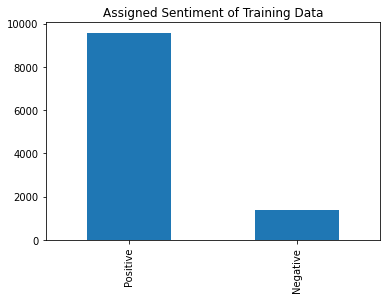

In [5]:
yelp_data_s['sentiment'].value_counts().plot(kind='bar')
plt.title('Assigned Sentiment of Training Data');

As you can see, most of our reviews are positive, let's see if we can sort it out even more for better results

In [6]:
sentiment = []
for i in range(len(yelp_data_s)):
    if yelp_data_s['Polarity'][i] >= 0.4:
        sentiment.append('Positive')
    if yelp_data_s['Polarity'][i] > 0.2 and yelp_data_s['Polarity'][i] < 0.4:
        sentiment.append('Slightly Positive')
    if yelp_data_s['Polarity'][i] <= 0.2 and yelp_data_s['Polarity'][i] > 0:
        sentiment.append('Slightly Negative')
    if yelp_data_s['Polarity'][i] < 0:
        sentiment.append('Negative')
yelp_data_s['sentiment'] = sentiment

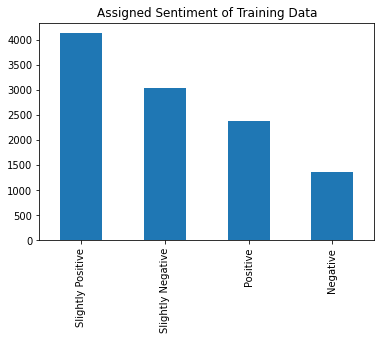

In [7]:
yelp_data_s['sentiment'].value_counts().plot(kind='bar')
plt.title('Assigned Sentiment of Training Data');

This is still a little biased towards positive reviews, but I did some research and it turns out that a large majority of all of yelp's reviews are positive so this makes sense

!['yelp reviews'](yelp_img.png)

Let's take a look at some of our features and how they change based on their category

In [8]:
yelp_data_s = yelp_data_s.rename(columns={'Stop_Words_%':'Stop_Words_P'})
yelp_data_s = yelp_data_s.rename(columns={'Positive_Words_%':'Positive_Words_P'})

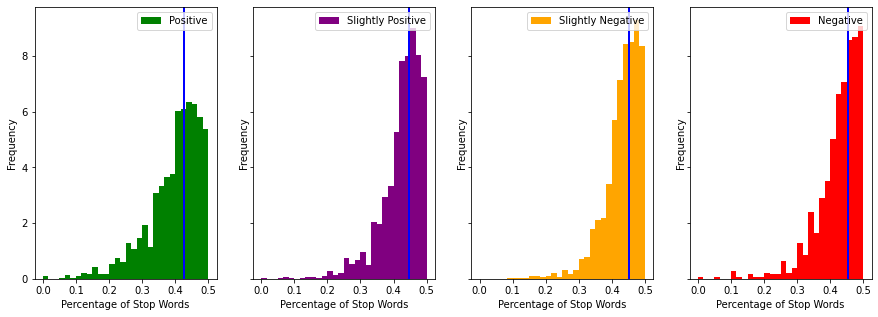

In [9]:
fig, axs = plt.subplots(1, 4, figsize = (15,5), sharex = True, sharey = True)
axs[0].hist(yelp_data_s[yelp_data_s.sentiment == 'Positive'].Stop_Words_P, bins = 30, density = True, range = (0,0.5), color = 'green', label = "Positive")
axs[0].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Positive'].Stop_Words_P), color = 'b', lw = 2, )
axs[0].legend(loc="upper right")

axs[1].hist(yelp_data_s[yelp_data_s.sentiment == 'Slightly Positive'].Stop_Words_P, bins = 30, density = True, range = (0,0.5), color = 'purple', label = "Slightly Positive")
axs[1].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Slightly Positive'].Stop_Words_P), color = 'b', lw = 2, )
axs[1].legend(loc="upper right")

axs[2].hist(yelp_data_s[yelp_data_s.sentiment == 'Slightly Negative'].Stop_Words_P, bins = 30, density = True, range = (0,0.5), color = 'orange', label = "Slightly Negative")
axs[2].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Slightly Negative'].Stop_Words_P), color = 'b', lw = 2, )
axs[2].legend(loc="upper right")

axs[3].hist(yelp_data_s[yelp_data_s.sentiment == 'Negative'].Stop_Words_P, bins = 30, density = True, range = (0,0.5), color = 'red', label = "Negative")
axs[3].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Negative'].Stop_Words_P), color = 'b', lw = 2, )
axs[3].legend(loc="upper right")

for ax in axs.flat:
    ax.set(xlabel='Percentage of Stop Words', ylabel='Frequency')
plt.show()

It looks like the average is around 40% for each category, let's try another feature

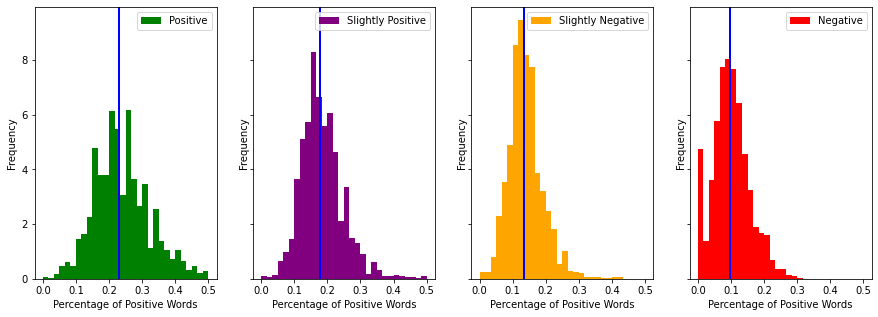

In [10]:
fig, axs = plt.subplots(1, 4, figsize = (15,5), sharex = True, sharey = True)
axs[0].hist(yelp_data_s[yelp_data_s.sentiment == 'Positive'].Positive_Words_P, bins = 30, density = True, range = (0,0.5), color = 'green', label = "Positive")
axs[0].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Positive'].Positive_Words_P), color = 'b', lw = 2, )
axs[0].legend(loc="upper right")

axs[1].hist(yelp_data_s[yelp_data_s.sentiment == 'Slightly Positive'].Positive_Words_P, bins = 30, density = True, range = (0,0.5), color = 'purple', label = "Slightly Positive")
axs[1].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Slightly Positive'].Positive_Words_P), color = 'b', lw = 2, )
axs[1].legend(loc="upper right")

axs[2].hist(yelp_data_s[yelp_data_s.sentiment == 'Slightly Negative'].Positive_Words_P, bins = 30, density = True, range = (0,0.5), color = 'orange', label = "Slightly Negative")
axs[2].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Slightly Negative'].Positive_Words_P), color = 'b', lw = 2, )
axs[2].legend(loc="upper right")

axs[3].hist(yelp_data_s[yelp_data_s.sentiment == 'Negative'].Positive_Words_P, bins = 30, density = True, range = (0,0.5), color = 'red', label = "Negative")
axs[3].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Negative'].Positive_Words_P), color = 'b', lw = 2, )
axs[3].legend(loc="upper right")

for ax in axs.flat:
    ax.set(xlabel='Percentage of Positive Words', ylabel='Frequency')
plt.show()

These looks different, but I'm not entirely convinced: let's take another look

In [11]:
print('Positive: ',np.median(yelp_data_s[yelp_data_s.sentiment == 'Positive'].Positive_Words_P))
print('Slightly Positive: ',np.median(yelp_data_s[yelp_data_s.sentiment == 'Slightly Positive'].Positive_Words_P))
print('Slightly Negative: ',np.median(yelp_data_s[yelp_data_s.sentiment == 'Slightly Negative'].Positive_Words_P))
print('Negative: ',np.median(yelp_data_s[yelp_data_s.sentiment == 'Negative'].Positive_Words_P))

Positive:  0.2307692307692307
Slightly Positive:  0.1772151898734177
Slightly Negative:  0.1333333333333333
Negative:  0.0967741935483871


This could be useful

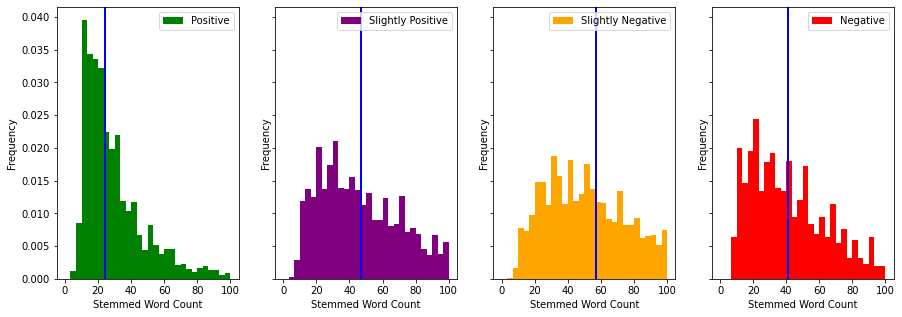

In [12]:
fig, axs = plt.subplots(1, 4, figsize = (15,5), sharex = True, sharey = True)
axs[0].hist(yelp_data_s[yelp_data_s.sentiment == 'Positive'].Stemmed_Word_Count, bins = 30, density = True, range = (0,100), color = 'green', label = "Positive")
axs[0].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Positive'].Stemmed_Word_Count), color = 'b', lw = 2, )
axs[0].legend(loc="upper right")

axs[1].hist(yelp_data_s[yelp_data_s.sentiment == 'Slightly Positive'].Stemmed_Word_Count, bins = 30, density = True, range = (0,100), color = 'purple', label = "Slightly Positive")
axs[1].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Slightly Positive'].Stemmed_Word_Count), color = 'b', lw = 2, )
axs[1].legend(loc="upper right")

axs[2].hist(yelp_data_s[yelp_data_s.sentiment == 'Slightly Negative'].Stemmed_Word_Count, bins = 30, density = True, range = (0,100), color = 'orange', label = "Slightly Negative")
axs[2].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Slightly Negative'].Stemmed_Word_Count), color = 'b', lw = 2, )
axs[2].legend(loc="upper right")

axs[3].hist(yelp_data_s[yelp_data_s.sentiment == 'Negative'].Stemmed_Word_Count, bins = 30, density = True, range = (0,100), color = 'red', label = "Negative")
axs[3].axvline(np.median(yelp_data_s[yelp_data_s.sentiment == 'Negative'].Stemmed_Word_Count), color = 'b', lw = 2, )
axs[3].legend(loc="upper right")

for ax in axs.flat:
    ax.set(xlabel='Stemmed Word Count', ylabel='Frequency')
plt.show()

No real discernable features here - sure the slightly negatives reviews have more than the slightly positive ones but then the negative reviews have about as much as the slighly positive ones. Not very consistent

It looks like the only really useful data we could use is the positive words %, but we'll see if that proves to be helpful when we make our model

Now that we have out data categorized we're going to need to converted our tokenized reviews into word vectors using two different approaches: CountVectorizer and TFIDF

## CountVectorizer

The CountVectorizer uses the bag of words approach to convert text to word counts and, more importantly, a vector. The vector for each word, paragraph, or sentence can then be compared to other vectors and we can see which ones are the most similar.

I'll start with the first two reviews from one location to demonstrate:

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

text = yelp_data_s['No_Stop_Words:Sentence'][0:2]
vectorizer = CountVectorizer()
vectorizer.fit(text)
vector = vectorizer.transform(text)

#summary
print('List of unique Words: ',vectorizer.vocabulary_)
print('')
print('Shape of the Sparse Matrix ',vector.shape)
print('')
print(vector.toarray())

List of unique Words:  {'chocolate': 7, 'cups': 9, 'amazing': 1, 'eating': 11, 'years': 30, 'always': 0, 'taste': 28, 'fantastic': 13, 'morris': 19, 'park': 21, 'bake': 5, 'shop': 25, 'become': 6, 'go': 14, 'spot': 26, 'atmosphere': 3, 'place': 22, 'great': 15, 'inviting': 17, 'love': 18, 'every': 12, 'thing': 29, 'ordered': 20, 'staff': 27, 'really': 24, 'pleasant': 23, 'definitely': 10, 'help': 16, 'anything': 2, 'come': 8, 'back': 4}

Shape of the Sparse Matrix  (2, 31)

[[1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 1 1 1 2 1 0 1 0 2 0 1 0 1 1 1 1 1 2 1 2 1 1 1 2 1 1 0 1 0]]


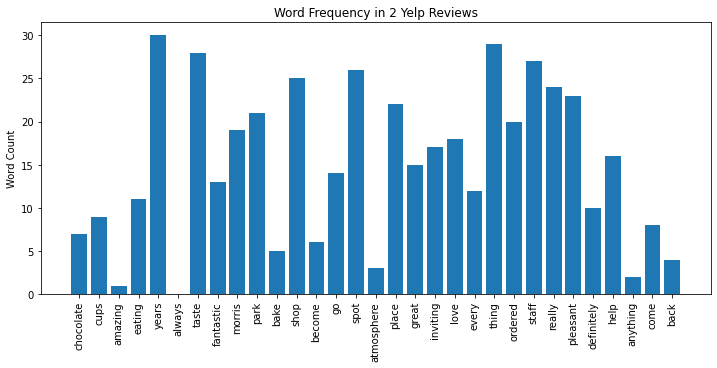

In [14]:
lists = vectorizer.vocabulary_.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(12,5))
plt.bar(x, y)
plt.xticks(rotation='vertical')
plt.title('Word Frequency in 2 Yelp Reviews')
plt.ylabel('Word Count')
plt.show()

Here we've got 31 unique words in two reviews. If there's a 1 that means the word appears and a 0 means the unique word did not make an appearance. 2s and other values simply mean that the unique word appears multiple times

## TFIDF

This stands for Term Frequency Inverse Document Frequency which means that in addition to measuring the word frequency in each review we can also measure how frequently a word appears among all lines of text. This is really important when it comes to picking out very unique words

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

text = yelp_data_s['No_Stop_Words:Sentence'][0:2]
Tvectorizer = TfidfVectorizer()
Tvectorizer.fit(text)
Tvector = Tvectorizer.transform(text)

#summary
print('List of unique Words: ',Tvectorizer.vocabulary_)
print('')
print('Shape of the Sparse Matrix ',Tvector.shape)
print('')
print(Tvector.toarray())

List of unique Words:  {'chocolate': 7, 'cups': 9, 'amazing': 1, 'eating': 11, 'years': 30, 'always': 0, 'taste': 28, 'fantastic': 13, 'morris': 19, 'park': 21, 'bake': 5, 'shop': 25, 'become': 6, 'go': 14, 'spot': 26, 'atmosphere': 3, 'place': 22, 'great': 15, 'inviting': 17, 'love': 18, 'every': 12, 'thing': 29, 'ordered': 20, 'staff': 27, 'really': 24, 'pleasant': 23, 'definitely': 10, 'help': 16, 'anything': 2, 'come': 8, 'back': 4}

Shape of the Sparse Matrix  (2, 31)

[[0.35355339 0.35355339 0.         0.         0.         0.
  0.         0.35355339 0.         0.35355339 0.         0.35355339
  0.         0.35355339 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.35355339 0.
  0.35355339]
 [0.         0.         0.16222142 0.16222142 0.16222142 0.32444284
  0.16222142 0.         0.16222142 0.         0.32444284 0.
  0.16222142 0.         0.16222142 0.16222142 0.16222142 0.16222142
  0

Lets see how we can make these metrics even better for our model

## Bigrams and min/max_df<a id='grams'></a>

I believe Bigrams will be very important for this model because of how people tend to write these yelp reivews. Phrases like 'No good' or 'not bad' are very common but if you tokenize them into individual words it completely changes the meaning. Bigrams turn these tokens into token pairs and create more unique pairs with more meaning

In [16]:
text = yelp_data_s['No_Stop_Words:Sentence'][0:2]
vectorizer = CountVectorizer(ngram_range=(1,2))
vectorizer.fit(text)
vector = vectorizer.transform(text)

#summary
print('List of unique Words: ',vectorizer.vocabulary_)
print('')
print('Shape of the Sparse Matrix ',vector.shape)
print('')
print(vector.toarray())

List of unique Words:  {'chocolate': 14, 'cups': 18, 'amazing': 2, 'eating': 23, 'years': 60, 'always': 0, 'taste': 56, 'fantastic': 27, 'chocolate cups': 15, 'cups amazing': 19, 'amazing eating': 3, 'eating years': 24, 'years always': 61, 'always taste': 1, 'taste fantastic': 57, 'morris': 38, 'park': 42, 'bake': 10, 'shop': 50, 'become': 12, 'go': 28, 'spot': 52, 'atmosphere': 6, 'place': 44, 'great': 30, 'inviting': 34, 'love': 36, 'every': 25, 'thing': 58, 'ordered': 40, 'staff': 54, 'really': 48, 'pleasant': 46, 'definitely': 20, 'help': 32, 'anything': 4, 'come': 16, 'back': 8, 'morris park': 39, 'park bake': 43, 'bake shop': 11, 'shop become': 51, 'become go': 13, 'go spot': 29, 'spot atmosphere': 53, 'atmosphere place': 7, 'place great': 45, 'great inviting': 31, 'inviting love': 35, 'love every': 37, 'every thing': 26, 'thing ordered': 59, 'ordered staff': 41, 'staff really': 55, 'really pleasant': 49, 'pleasant definitely': 47, 'definitely help': 22, 'help anything': 33, 'any

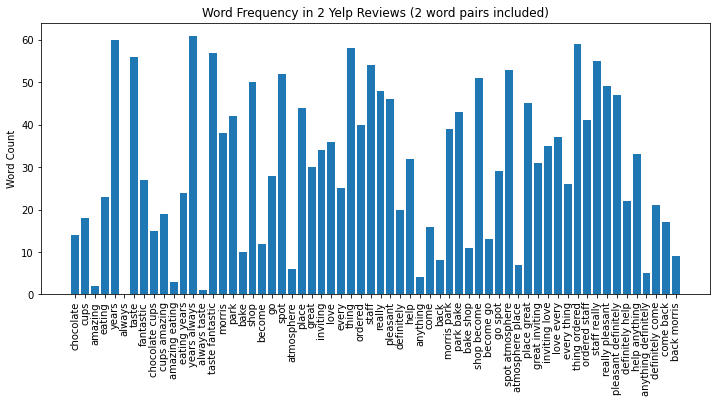

In [17]:
lists = vectorizer.vocabulary_.items() # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(12,5))
plt.bar(x, y)
plt.xticks(rotation='vertical')
plt.title('Word Frequency in 2 Yelp Reviews (2 word pairs included)')
plt.ylabel('Word Count')
plt.show()

min_df and max_df basically set limits on how much of the data we want to display in these arrays. min_df specifies how infrequently a word can appear to be significant and max_df does this oppositive

Specifying min and max_df saves time and memory for the code and filters our the words that only appear a couple of times (which are usually spelling errors anyway!)

In [18]:
text = yelp_data_s['No_Stop_Words:Sentence'][0:3]
vectorizer = CountVectorizer(ngram_range=(1,2),min_df=2)
vectorizer.fit(text)
vector = vectorizer.transform(text)

#summary
print('List of unique Words: ',vectorizer.vocabulary_)
print('')
print('Shape of the Sparse Matrix ',vector.shape)
print('')
print(vector.toarray())

List of unique Words:  {'shop': 5, 'go': 2, 'great': 3, 'staff': 6, 'really': 4, 'definitely': 1, 'back': 0}

Shape of the Sparse Matrix  (3, 7)

[[0 0 0 0 0 0 0]
 [1 2 1 1 1 2 1]
 [1 1 1 1 3 1 2]]


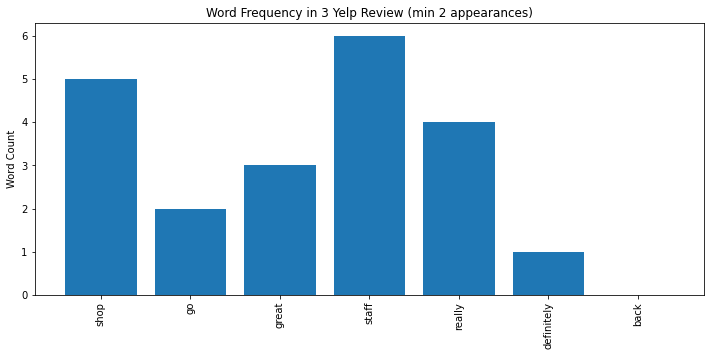

In [19]:
lists = vectorizer.vocabulary_.items() # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(12,5))
plt.bar(x, y)
plt.xticks(rotation='vertical')
plt.title('Word Frequency in 3 Yelp Review (min 2 appearances)')
plt.ylabel('Word Count')
plt.show()

In this case, out of 3 reviews these are the only words that appeared in 2 or more

## Creating a Training Dataset<a id='Train'></a>

In [47]:
text = yelp_data_s['Stemmed:Sentence']
Tvectorizer = TfidfVectorizer()
Tvectorizer.fit(text)
Tvector = Tvectorizer.transform(text)

In [48]:
voc = Tvectorizer.vocabulary_
df = pd.DataFrame(Tvector.toarray(),columns=voc)

col_name1 ='Name'
col_name2 = 'Review'
col_name3 = 'Polarity'
col_name4 = 'Sentiment'
col_name5 = 'Positive_Words_P'

col1 = yelp_data_s['Name']
col2 = yelp_data_s['Review']
col3 = yelp_data_s['Polarity']
col4 = yelp_data_s['sentiment']
col5 = yelp_data_s['Positive_Words_P']

df.insert(0,col_name1,col1)
df.insert(1,col_name2,col2)
df.insert(2,col_name3,col3)
df.insert(3,col_name4,col4)
df.insert(4,col_name5,col5)

In [49]:
morDf = df[df['Name'] == "Morris Park Bake Shop"]

In [51]:
print(morDf.iloc[15]['Polarity'])
print('Sentiment:', morDf.iloc[15]['Sentiment'])
x = morDf.iloc[15]['chocol':].sort_values(ascending=False)[:10]
x

0.425
Sentiment: Positive


nonsumm            0.480194
1245pm             0.384636
dee                0.364553
tipofthehat        0.346561
couplea            0.298093
bustl              0.266512
awardwin           0.235031
extracurricular    0.211855
expectthey         0.167201
photogen            0.16599
Name: 15, dtype: object

Now that we have these new features, let's create a dataset that we can use to train our model. In this case, I'm going to use the TFIDF along with our new 'dummy' variables to make our model even more accurate

Accuracy Score:  0.6767215112736137

Overall Statistics : 

ACC Macro                                                         0.83836
F1 Macro                                                          0.67224
FPR Macro                                                         0.11928
Kappa                                                             0.53803
Overall ACC                                                       0.67672
PPV Macro                                                         0.72639
SOA1(Landis & Koch)                                               Moderate
TPR Macro                                                         0.64557
Zero-one Loss                                                     1061

Class Statistics :

Classes                                                           Negative              Positive              Slightly Negative     Slightly Positive     
ACC(Accuracy)                                                     0.93114               0.87355     

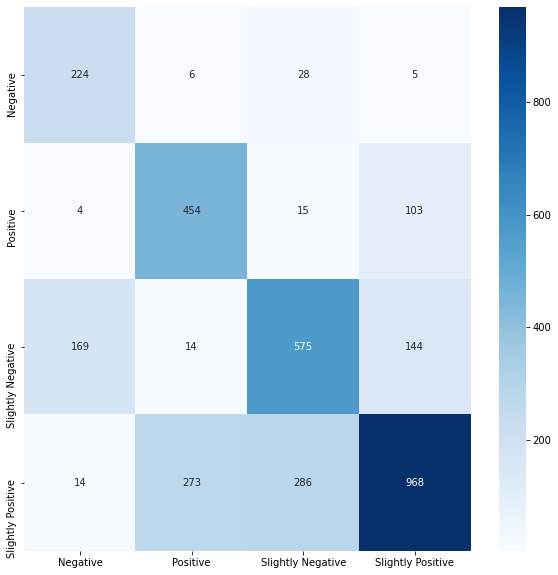

In [29]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from pycm import *

X = df.iloc[0:,4:]
y = df.Sentiment

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=0,test_size=0.3)

clf2 = LogisticRegression(solver = 'lbfgs')
model = Pipeline([('classifier',clf2)])
model.fit(Xtrain, ytrain)
predictions = model.predict(Xtest)
mat = confusion_matrix(predictions,ytest)
cm_df =  pd.DataFrame(mat, index= [i for i in ['Negative','Positive',
                                               'Slightly Negative',
                                              'Slightly Positive']],
                     columns= [i for i in ['Negative','Positive',
                                               'Slightly Negative',
                                              'Slightly Positive']])
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap='Blues',fmt='g')

cm = ConfusionMatrix(actual_vector=list(ytest), predict_vector=list(predictions))
print('Accuracy Score: ',accuracy_score(predictions,ytest))
print('')
cm.stat(summary=True)

This is an alright start, but lets see if we can change the number of ngrams and the minimum/maximum number of occurances in the TFIDF vectorizer to find the optimal result and prevent overfitting

In [30]:
def mindf_test(numbers):
    scores = {}
    for num in numbers:
        text = yelp_data_s['Stemmed:Sentence']
        Tvectorizer = TfidfVectorizer(min_df=num)
        Tvectorizer.fit(text)
        Tvector = Tvectorizer.transform(text)
        
        voc = Tvectorizer.vocabulary_
        df = pd.DataFrame(Tvector.toarray(),columns=voc)

        col_name1 ='Name'
        col_name2 = 'Review'
        col_name3 = 'Polarity'
        col_name4 = 'Sentiment'
        col_name5 = 'Positive_Words_P'

        col1 = yelp_data_s['Name']
        col2 = yelp_data_s['Review']
        col3 = yelp_data_s['Polarity']
        col4 = yelp_data_s['sentiment']
        col5 = yelp_data_s['Positive_Words_P']

        df.insert(0,col_name1,col1)
        df.insert(1,col_name2,col2)
        df.insert(2,col_name3,col3)
        df.insert(3,col_name4,col4)
        df.insert(4,col_name5,col5)
        
        X = df.iloc[0:,4:]
        y = df.Sentiment

        Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=0,test_size=0.3)

        clf2 = LogisticRegression(solver = 'lbfgs')
        model = Pipeline([('classifier',clf2)])
        model.fit(Xtrain, ytrain)
        predictions = model.predict(Xtest)
        
        score = accuracy_score(predictions,ytest)
        
        scores[num] = score
    return scores

Now lets create our list of number of minimum occurances. We don't want to set it too low or too high so lets start with 5-50. If we notice the trend moving up or down towards the ends of the curve we can change it but I think this range should capture the most accurate version of the model

In [31]:
min_list1 = list(range(5,50))

In [32]:
scores_list1 = mindf_test(min_list1)

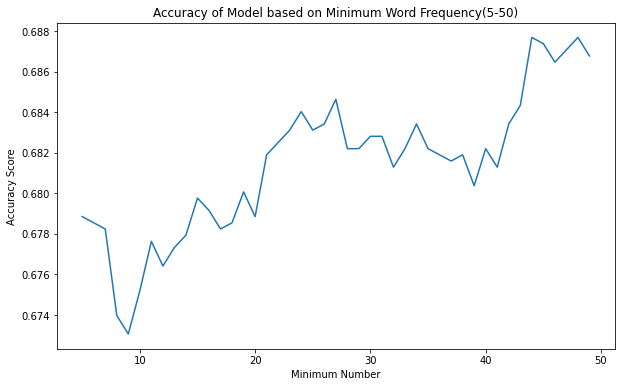

In [33]:
x = scores_list1.keys()
y = scores_list1.values()
plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.title('Accuracy of Model based on Minimum Word Frequency(5-50)')
plt.xlabel('Minimum Number')
plt.ylabel('Accuracy Score');

Looks like we're getting more accurate as we raise the minumum, let's try some higher values

In [34]:
min_list2 = list(range(40,100))
scores_list2 = mindf_test(min_list2)

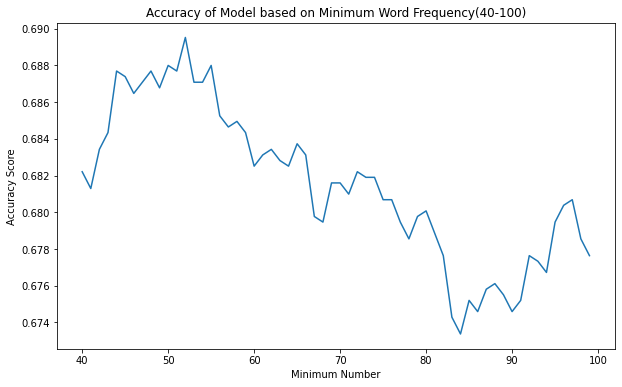

In [35]:
x = scores_list2.keys()
y = scores_list2.values()
plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.title('Accuracy of Model based on Minimum Word Frequency(40-100)')
plt.xlabel('Minimum Number')
plt.ylabel('Accuracy Score');

In [83]:
import operator
max(scores_list2.items(), key=operator.itemgetter(1))[0]

52

looks like 52 is our ideal number for minimum frequency

In [74]:
def ngrams_test(numbers):
    scores = {}
    for num in numbers:
        text = yelp_data_s['Stemmed:Sentence']
        Tvectorizer = TfidfVectorizer(ngram_range=(1,num),min_df=52)
        Tvectorizer.fit(text)
        Tvector = Tvectorizer.transform(text)
        
        voc = Tvectorizer.vocabulary_
        df = pd.DataFrame(Tvector.toarray(),columns=voc)

        col_name1 ='Name'
        col_name2 = 'Review'
        col_name3 = 'Polarity'
        col_name4 = 'Sentiment'
        col_name5 = 'Positive_Words_P'

        col1 = yelp_data_s['Name']
        col2 = yelp_data_s['Review']
        col3 = yelp_data_s['Polarity']
        col4 = yelp_data_s['sentiment']
        col5 = yelp_data_s['Positive_Words_P']

        df.insert(0,col_name1,col1)
        df.insert(1,col_name2,col2)
        df.insert(2,col_name3,col3)
        df.insert(3,col_name4,col4)
        df.insert(4,col_name5,col5)
        
        X = df.iloc[0:,4:]
        y = df.Sentiment

        Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=0,test_size=0.3)

        clf2 = LogisticRegression(solver = 'lbfgs')
        model = Pipeline([('classifier',clf2)])
        model.fit(Xtrain, ytrain)
        predictions = model.predict(Xtest)
        
        score = accuracy_score(predictions,ytest)
        
        scores[num] = score
    return scores

In [78]:
ngram_list = [1,2,3,4]
ngram_scores = ngrams_test(ngram_list)

Text(0, 0.5, 'Accuracy Score')

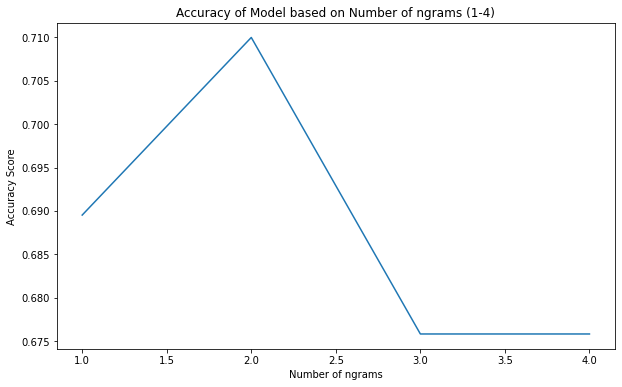

In [90]:
x = ngram_scores.keys()
y = ngram_scores.values()
plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.title('Accuracy of Model based on Number of ngrams (1-4)')
plt.xlabel('Number of ngrams')
plt.ylabel('Accuracy Score')

In this case, our ideal TFIDF output is 2 ngrams with a min_df of 52! Let's create a dataframe to export for modeling

In [85]:
text = yelp_data_s['Stemmed:Sentence']
Tvectorizer = TfidfVectorizer(min_df=52,ngram_range=(1,2))
Tvectorizer.fit(text)
Tvector = Tvectorizer.transform(text)

voc = Tvectorizer.vocabulary_
df = pd.DataFrame(Tvector.toarray(),columns=voc)

col_name1 ='Name'
col_name2 = 'Review'
col_name3 = 'Polarity'
col_name4 = 'Sentiment'
col_name5 = 'Positive_Words_P'

col1 = yelp_data_s['Name']
col2 = yelp_data_s['Review']
col3 = yelp_data_s['Polarity']
col4 = yelp_data_s['sentiment']
col5 = yelp_data_s['Positive_Words_P']

df.insert(0,col_name1,col1)
df.insert(1,col_name2,col2)
df.insert(2,col_name3,col3)
df.insert(3,col_name4,col4)
df.insert(4,col_name5,col5)

In [87]:
df.head()

,Name,Review,Polarity,Sentiment,Positive_Words_P,chocol,cup,amaz,eat,year,...,linguin,linguini,jimmi,player,juliana,pool tabl,castl,falafel,paella,white castl
0,Morris Park Bake Shop,'The chocolate cups are amazing! Have been eat...,0.500000,Positive,0.222222,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Morris Park Bake Shop,'Morris Park Bake Shop has become my go to spo...,0.338889,Slightly Positive,0.206897,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,Morris Park Bake Shop,'I thought the cookies and biscotti were prett...,0.314583,Slightly Positive,0.130435,0.0,0.0,0.0,0.0,0.160339,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Morris Park Bake Shop,'Guys.... so Im a big time biscotti connoisseu...,0.238068,Slightly Positive,0.127660,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.149255,0.0,0.0,0.0
4,Morris Park Bake Shop,'I had a craving for a special type of cake wi...,0.314643,Slightly Positive,0.218750,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## Conclusion

As you can see, with just a simple model we're off to a decent start at around 70% accuracy. Once we take these features and apply them to a better model and experiment with number of ngrams and all things like that we should see much better performance!

In the next notebook, we're finally going to build our model which we'll need to first decide which model to use and how to improve on it.

In [88]:
df.to_csv(r'yelp_data_sentiment.csv',index=False)